# Decision Tree
---

In [6]:
import pandas as pd
import numpy as np
import scipy.sparse
import time
np.set_printoptions(suppress=True)
import operator
import time
from sklearn import tree
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection
import graphviz
from subprocess import check_call
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Decision tree class


In [2]:
class Node():
    def __init__(self, feature_index=None, left=None, right=None, info_gain=None, value=None):
       
        self.feature_index_ = feature_index
        self.left_ = left
        self.right_ = right
        self.info_gain_ = info_gain
        self.value_ = value

        
class Tree():
    def __init__(self, max_depth=2, gain_method="ginigain"):
        
        self.root_ = None
        self.max_depth = max_depth
        self.gain_method = gain_method
        self.classes_ = None
        self.n_features_in_ = None
        self.index = 0
        self.nodes_list = []
        self.edges_list = []
        self.gini_list = []
        self.features_list = []
        self.values_list = []
        self.edges_labels = []
        self.sparse = False
        
    def generateUniqueDict(self, X):
        (unique, counts) = np.unique(X, return_counts=True)
        output = {}
        for index, name in enumerate(unique):
            output[name] = index
        return output

    def freq(self, X, prob=True):
        (unique, counts) = np.unique(X, return_counts=True)
        if prob:
            return unique, counts / (np.size(X))
        return unique, counts

    def freq2(self, X, Y, prob=True):
        if scipy.sparse.issparse(X):
            pij = np.zeros((2,2))
            xy, x_ind, y_ind = np.intersect1d(X.indices, Y.indices, return_indices=True)
            if prob:
                pij[1, 1] = (xy.shape[0])/X.shape[0]
                pij[0, 1] = (-xy.shape[0] + Y.indices.shape[0]) / X.shape[0]
                pij[1, 0] = (-xy.shape[0] + X.indices.shape[0]) / X.shape[0]
                pij[0, 0] = 1 - np.sum(pij)       
            else:
                pij[1, 1] = (xy.shape[0])
                pij[0, 1] = (-xy.shape[0] + Y.indices.shape[0])
                pij[1, 0] = (-xy.shape[0] + X.indices.shape[0])
                pij[0, 0] = X.shape[0] - np.sum(pij)      
            return pij
        else:
            dictX = self.generateUniqueDict(X)
            dictY = self.generateUniqueDict(Y)
            nij = np.zeros((len(dictX), len(dictY)))
            for Xvalue, Yvalue in zip(X, Y):
                nij[dictX[Xvalue], dictY[Yvalue]] += 1
            if prob:
                return nij/np.sum(nij)
            return nij



    def entropy(self, pij):
        pij += 1e-16
        return -np.sum(pij * np.log2(pij))

    def infoGain(self, pij):
        return self.entropy(np.sum(pij, axis=0)) + self.entropy(np.sum(pij, axis=1)) - self.entropy(pij)


    def kappa(self, pij):
        return self.infoGain(pij) / self.entropy(np.sum(pij, axis=0))

    def gini(self, pij):
        return 1 - np.sum(np.square(pij))

    def giniGain(self, pij):
        pij += 1e-16
        suma = 0
        k = pij.shape[0]
        for i in range(k):
            pi = np.sum(pij[i, :])

            suma += self.gini(pij[i, :]/pi)*pi
        return self.gini(np.sum(pij, axis=0)) - suma
        
    def fit(self, X, Y):
        self.classes_ = np.unique(Y)
        self.n_features_in_ = X.shape[1]
        self.nodes_list.append(self.index)
        self.root = self.__buildTree(X, Y, self.index)
        if scipy.sparse.issparse(X):
            self.sparse = True
        return self
        
    def __buildTree(self, X, Y, parent, curr_depth=0):
        if scipy.sparse.issparse(X):
            if Y.data.shape[0] != Y.shape[0] and curr_depth < self.max_depth and Y.data.shape[0] != 0:
                gains = []
                if self.gain_method == "ginigain":
                    for i in range(X.shape[1]):
                        if X[:, i].nnz == 0:
                            gains.append(0)
                            continue
                        pij = self.freq2(X[:, i], Y, True)
                        gains.append(self.giniGain(pij))
                elif self.gain_method == "infogain":
                    for i in range(X.shape[1]):
                        if X[:, i].nnz == 0:
                            gains.append(0)
                            continue
                        pij = self.freq2(X[:, i], Y, True)
                        gains.append(self.infoGain(pij))
                else:
                    raise ValueError("Unknown info gain method.")

                if len(np.unique(gains)) > 1:      
                    best_feature = np.argmax(gains)
                    
                    self.gini_list.append(max(gains))
                    self.features_list.append(best_feature)
                    self.values_list.append("---")
                    
                    
                    self.index += 1
                    self.nodes_list.append(self.index)
                    self.edges_list.append([parent, self.index])
                    self.edges_labels.append("False")
                    indexes = np.setdiff1d(range(X.shape[0]), X[:, best_feature].nonzero()[0])
                    left_subtree = self.__buildTree(X[indexes],Y[indexes], self.index, curr_depth+1)
                    
                    self.index += 1
                    self.nodes_list.append(self.index)
                    self.edges_list.append([parent, self.index])
                    self.edges_labels.append("True")
                    indexes = X[:, best_feature].nonzero()[0]
                    right_subtree = self.__buildTree(X[indexes],Y[indexes],self.index, curr_depth+1)

                    return Node(best_feature,
                                left_subtree,
                                right_subtree,
                                gains[best_feature])
            
            self.gini_list.append("---")
            self.features_list.append("---")
            value=(0 if (Y.shape[0] - Y.data.shape[0]) > Y.data.shape[0] else 1)
            self.values_list.append(value)
            return Node(value=value)
        
        else:
            if len(np.unique(Y)) > 1 and curr_depth < self.max_depth:
                gains = []
                if self.gain_method == "ginigain":
                    for i in range(X.shape[1]):
                        pij = self.freq2(X[:, i], Y, True)
                        gains.append(self.giniGain(pij))
                elif self.gain_method == "infogain":
                    for i in range(X.shape[1]):
                        pij = self.freq2(X[:, i], Y, True)
                        gains.append(self.infoGain(pij))
                else:
                    raise ValueError("Unknown info gain method.")

                if len(np.unique(gains)) > 1:      
                    best_feature = np.argmax(gains)
                    
                    self.gini_list.append(max(gains))
                    self.features_list.append(best_feature)
                    self.values_list.append("---")
                    
                    self.index += 1
                    self.nodes_list.append(self.index)
                    self.edges_list.append([parent, self.index])
                    self.edges_labels.append("False")
                    indexes = X[:, best_feature] == 0
                    left_subtree = self.__buildTree(X[indexes],Y[indexes], self.index, curr_depth+1)
                    
                    self.index += 1
                    self.nodes_list.append(self.index)
                    self.edges_list.append([parent, self.index])
                    self.edges_labels.append("True")
                    indexes = X[:, best_feature] == 1
                    right_subtree = self.__buildTree(X[indexes],Y[indexes], self.index, curr_depth+1)
                    

                    return Node(best_feature,
                                left_subtree,
                                right_subtree,
                                gains[best_feature])
                
            self.gini_list.append("---")
            self.features_list.append("---")
            value=max(list(Y), key = list(Y).count)
            self.values_list.append(value)
            return Node(value=value)
    
    def predict(self, X):
        preditions = None
        if scipy.sparse.issparse(X):
            if isinstance(X, scipy.sparse.csc_matrix):
                X = X.tocsr()
            preditions = [self.make_prediction(X[i], self.root) for i in range(X.shape[0])]
        else:
            preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        if scipy.sparse.issparse(X):
            if tree.value_!=None: 
                return tree.value_
            feature_val = x[0, tree.feature_index_]
            if feature_val == 0:
                return self.make_prediction(x, tree.left_)
            else:
                return self.make_prediction(x, tree.right_)
        else:
            if tree.value_!=None: 
                return tree.value_
            feature_val = x[tree.feature_index_]
            if feature_val == 0:
                return self.make_prediction(x, tree.left_)
            else:
                return self.make_prediction(x, tree.right_)
        
    def get_params(self, deep=True):
        return {"max_depth": self.max_depth, "gain_method": self.gain_method}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def score(self, X, Y_true):
        from sklearn.metrics import accuracy_score
        Y_pred = self.predict(X)
        if scipy.sparse.issparse(X):
            return accuracy_score(Y_true.toarray(), Y_pred)
        return accuracy_score(Y_true, Y_pred)
    
    def visualization(self):
        dot = graphviz.Digraph(comment="Decision tree")
        for i, j, k, c in zip(self.nodes_list, self.gini_list, self.features_list, self.values_list):
            dot.node(str(i), f"Label: {str(i)}\nGain: {str(j)[0:6]}\nFeature: {k}\n\nClass: {c}", shape="box")

        for i, l in zip(self.edges_list, self.edges_labels):
            dot.edge(str(i[0]), str(i[1]), shape="box", label=f"{l}")

        dot.render(filename=str(self.sparse) + "_" + str(self.max_depth) + '.dot')
        return dot
        

# Zoo

## GridSearchCV

In [6]:
df = pd.read_csv("zoo.csv")
df["legs"] = df["legs"] > 2
X = df.iloc[:, 1:-1].to_numpy()
Y = df.iloc[:, -1]

le = preprocessing.LabelEncoder()
le.fit(Y)
Y = le.transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

clf = Tree(max_depth=2, gain_method="ginigain")
clf.fit(X_train, Y_train)
print("Predicted values: ", clf.predict(X_test))

parameters = {"max_depth":[2,3,4,5,6,7,8,9,10], "gain_method":["ginigain", "infogain"]}
t0 = time.time()
grid = model_selection.GridSearchCV(clf, parameters)
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_score_)
t1 = time.time()
print(f"Estimated time of GridSearchCV(): {t1-t0}")


Predicted values:  [2, 5, 5, 2, 5, 2, 5, 5, 2, 5, 5, 5, 5, 2, 5, 2, 1, 2, 1, 1, 1]
{'gain_method': 'ginigain', 'max_depth': 7}
0.925
Estimated time of GridSearchCV(): 1.379981517791748


In [7]:
clf = Tree(max_depth=7, gain_method="ginigain")
t0 = time.time()
clf.fit(X_train, Y_train)
t1 = time.time()
print(f"Estimated time of fit(): {t1-t0}")
print(Y_test)
t0 = time.time()
print(clf.predict(X_test))
t1 = time.time()
print(f"Estimated time of predict(): {t1-t0}")

Estimated time of fit(): 0.024930477142333984
[6 5 5 6 5 3 5 5 2 5 5 5 5 0 5 2 1 3 1 1 1]
[3, 5, 5, 6, 5, 3, 5, 5, 2, 5, 5, 5, 5, 0, 5, 2, 1, 3, 1, 1, 1]
Estimated time of predict(): 0.0


## Measures

In [8]:
Y_pred = clf.predict(X_test)

In [15]:
f1_score(Y_test, Y_pred, average="micro")

0.9523809523809523

In [5]:
cross_val_score(clf, X, Y, cv=10)

array([1. , 1. , 1. , 1. , 0.9, 0.9, 1. , 0.9, 0.9, 1. ])

In [16]:
confusion_matrix(Y_test, Y_pred)

array([[ 1,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  1,  0,  1]], dtype=int64)

In [17]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       0.67      1.00      0.80         2
           5       1.00      1.00      1.00        10
           6       1.00      0.50      0.67         2

    accuracy                           0.95        21
   macro avg       0.94      0.92      0.91        21
weighted avg       0.97      0.95      0.95        21



## Visualization

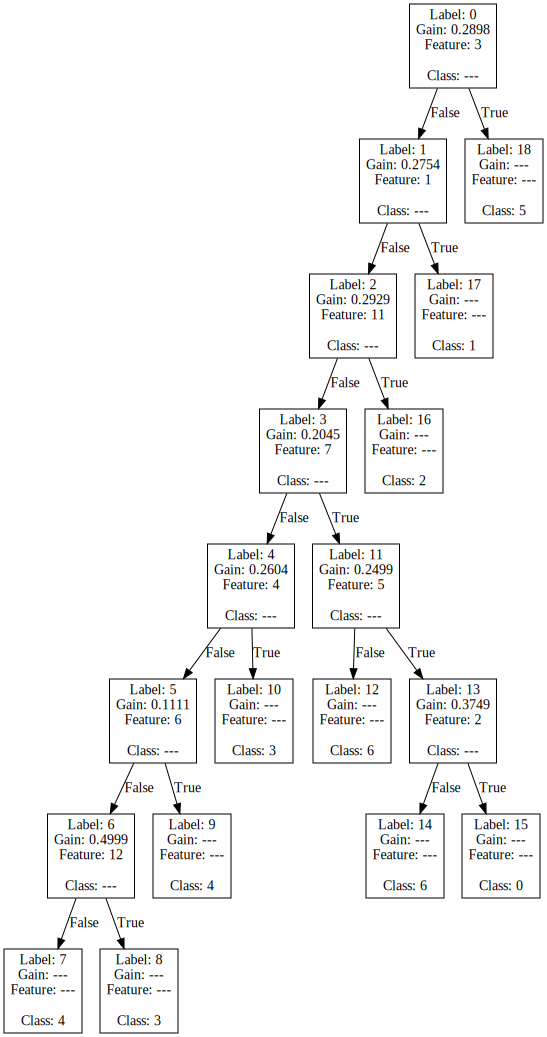

In [6]:
clf.visualization()

## Sklearn - Zoo

In [7]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, Y_train)

parameters = {"max_depth":[2,3,4,5,6,7,8,9,10], "criterion":["gini", "entropy"]}
t0 = time.time()
grid = model_selection.GridSearchCV(clf, parameters)
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_score_)
t1 = time.time()
print(f"Estimated time of GridSearchCV(): {t1-t0}")


{'criterion': 'gini', 'max_depth': 7}
0.95
Estimated time of GridSearchCV(): 0.12070274353027344


c:\users\gl503\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


---
___

# Reuters

In [10]:
from scipy.sparse import coo_matrix
from sklearn.datasets import fetch_rcv1
from sklearn.utils import resample
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix

rcv1 = fetch_rcv1()

X = rcv1.data
Y = rcv1.target[:, 89]
X = X>0
X = X.tocsc()
Y = Y.tocsc()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [4]:
X_train = X_train.tocsc()
X_test = X_test.tocsc()
Y_train = Y_train.tocsc()
Y_test = Y_test.tocsc()

## Fit & Predict

In [13]:
clf = Tree(max_depth=8, gain_method="ginigain")
t0 = time.time()
clf.fit(X_train, Y_train)
t1 = time.time()
print(f"Estimated time of fit(): {t1-t0}")
t0 = time.time()
clf.predict(X_test)
t1 = time.time()
print(f"Estimated time of predict(): {t1-t0}")

Estimated time of fit(): 825.5796134471893
Estimated time of predict(): 39.376755714416504


## Predict

In [14]:
Y_pred = clf.predict(X_test)

## Measures

In [18]:
f1_score(Y_test.toarray(), Y_pred)

0.6506709321958589

In [19]:
confusion_matrix(Y_test.toarray(), Y_pred)

array([[153291,   1117],
       [  2814,   3661]], dtype=int64)

In [21]:
print(classification_report(Y_test.toarray(), Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    154408
           1       0.77      0.57      0.65      6475

    accuracy                           0.98    160883
   macro avg       0.87      0.78      0.82    160883
weighted avg       0.97      0.98      0.97    160883



## Visualization

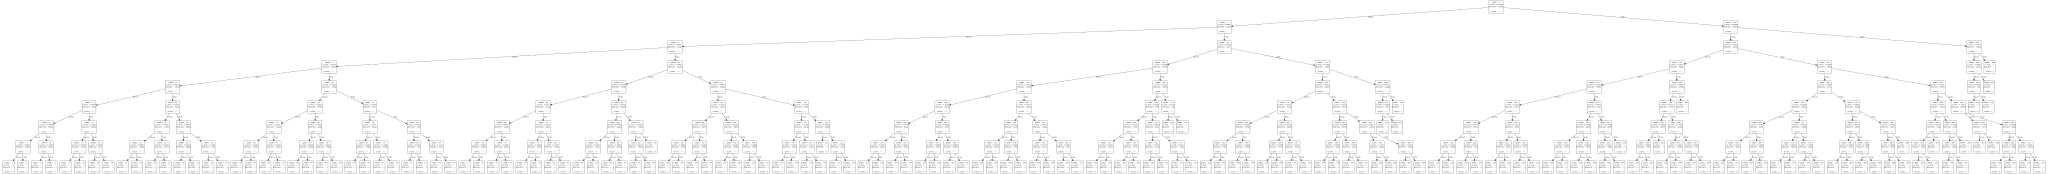

In [22]:
clf.visualization()